## Model Creation

Let's create a model first, with some vocab.
The output is a dataset.

In [1]:
%pip install librosa numpy soundfile torch torchaudio datasets evaluate transformers matplotlib jiwer

Note: you may need to restart the kernel to use updated packages.


## Dataset

First, let's load our data in a Hugging Face dataset.

In [2]:
import os
import gc

import datasets
import pandas as pd
import soundfile
import torch

import ipa_encoder
from src.phonemizer import commonvoice, text_phonemizer

LANGUAGES = "fr", "it"
USE_IN_HOUSE = False
DATASETS_DIR = "datasets"

def clear_cache():
    gc.collect()
    with torch.no_grad():
        torch.cuda.empty_cache()
    

def check_audios_valid(file_name):
    """Mark file invalid when it cannot be read."""
    if not os.path.exists(file_name):
        return False
    
    with open(file_name, 'rb') as file:
        try:
            soundfile.read(file)
            return True
        except soundfile.LibsndfileError:
            return False


def get_in_house_dataset(languages):
    ground_truth_files_path = {
        "fr": "Phoneme_Deleletion_ground_truth_FR.csv",
        "it": "Decoding_ground_truth_IT.csv"
    }

    audio_files_dict = {
        "fr": "Phoneme_Deletion_FR",
        "it": "Decoding_IT"
    }
    dataframes_list = []
    base_features = {
        "file_name": datasets.Value("string"),
        "API_target": datasets.Value("string"),
        "phase": datasets.Value("string"),
        "accuracy_coder1": datasets.Value("uint8"),
        "accuracy_coder2": datasets.Value("uint8")
    }
    for language in languages:
        dataframe = pd.read_csv(
            "Hackathon_ASR/1_Ground_truth/" + ground_truth_files_path[language],
            usecols=list(base_features.keys()) + ["language"]
        )
        dataframe = dataframe.dropna(subset=list(base_features.keys()))
        audio_files_path = "Hackathon_ASR/2_Audiofiles/" + audio_files_dict[language] + "_T1/"
        dataframe = dataframe.assign(
            audio=pd.Series([
                audio_files_path + audio 
                for audio in dataframe["file_name"]
            ]).values
        )
        dataframe = dataframe[[check_audios_valid(audio) for audio in dataframe["audio"]]]
        if language == "it":
            coders = "accuracy_coder1", "accuracy_coder2"
            # Filter out any null value
            dataframe = dataframe[[
                "NA" not in x + y 
                for x, y in zip(dataframe[coders[0]], dataframe[coders[1]])
            ]]
            # Collapse the accuracies here
            for coder in coders:
                dataframe[coder] = [sum(map(int, row)) for row in dataframe[coder].str.split(" ")]
            
        dataframes_list.append(dataframe)

    dataframe = pd.concat(dataframes_list)
    return datasets.Dataset.from_pandas(dataframe)


def load_phonemized_in_house_dataset(languages):
    base_features = {
        "file_name": datasets.Value("string"),
        "API_target": datasets.Value("string"),
        "accuracy_coder1": datasets.Value("uint8"),
        "accuracy_coder2": datasets.Value("uint8")
    }
    features = datasets.Features(base_features)
    dataset = datasets.load_dataset(
        "csv", 
        data_files="Hackathon_ASR/1_Ground_truth/" + ground_truth_files_path[language],
        features=features,
        split="train",
        keep_default_na=False
    )
    ds = ds.add_column("language", [language] * dataset.num_rows)

    for language in languages:

        dataset_path = f"datasets/phonemized_{language}.csv"

        if not os.path.exists(dataset_path):
            print("Regenerating IPA CSV file")
            ipa_encoder.regenerate_ipa_csv(language)


    # 2. Define initial features: audio paths as plain strings, phonemes as plain strings
    features = datasets.Features({
        "file_name": datasets.Value("string"),
        "phonemes_coder1": datasets.Value("string"),
        "phonemes_coder2": datasets.Value("string"),
        "API_target": datasets.Value("string")
    })

    # 3. Load the CSV into a DatasetDict (default split is 'train')
    dataset = datasets.load_dataset("csv", data_files=dataset_path, features=features, split="train")

    dataset = dataset.map(
        lambda data_row: {"audio": audio_files_path + data_row["file_name"]},
        desc="Select audio files path"
    )


    print(dataset.num_rows, "rows before filtering")
    dataset = dataset.filter(check_audios_valid, desc="Filtering out unreadable files")
    print(dataset.num_rows, "rows after filtering")

    dataset = dataset.map(
        split_phonemes, 
        remove_columns=["phonemes_coder1", "phonemes_coder2"],
        desc="Phonemize data"
    )

    # 7. Cast the phoneme_sequence column to a Sequence of strings
    dataset = dataset.cast_column(
        "target_phonemes1",
        datasets.Sequence(feature=datasets.Value("string"))
    ).cast_column(
        "target_phonemes2",
        datasets.Sequence(feature=datasets.Value("string"))
    )

    return dataset


def get_common_voice_phonemized_dataset(languages, limit=-1):
    """Phonemized dataset from common voice."""
    dataset = commonvoice.get_phonemized_datasets(languages, limit_items=limit)
    return dataset.map(
        lambda x: {"target_phonemes1": x.split(" ")},
        input_columns=["target_phonemes1"]
    ).cast_column(
        "target_phonemes1",
        datasets.Sequence(feature=datasets.Value("string"))
    )


# 6. Map + split phoneme strings into lists
def split_in_bracket(string):
    output = []
    in_brackets = False
    if string is None:
        return output
    for char in string:
        if in_brackets:
            output[-1] += char
        else:
            output.append(char)

        if char == '[':
            in_brackets = True
        elif char == ']':
            if output[-1] not in VOCAB:
                print(f"Removing {output.pop()}")
            in_brackets = False
    return output


def split_phonemes(data_row):
    """Split each phoneme into a list."""
    data_row["target_phonemes1"] = split_in_bracket(data_row["phonemes_coder1"])
    data_row["target_phonemes2"] = split_in_bracket(data_row["phonemes_coder2"])
    return data_row


def create_phonemized_dataset(max_rows=-1):
    clear_cache()
    dataset = get_common_voice_phonemized_dataset(LANGUAGES, max_rows)

    # 5. Cast 'audio' to the Audio type (will load the file when you access it)
    dataset = dataset.cast_column("audio", datasets.Audio(sampling_rate=16_000))

    return dataset

dataset_path = f"{DATASETS_DIR}/phonemized_{'_'.join(LANGUAGES)}{'' if USE_IN_HOUSE else '_common'}"

num_audios = 8192

if os.path.exists(dataset_path):
    dataset = datasets.load_from_disk(dataset_path)
    if dataset.num_rows < num_audios:
        dataset = create_phonemized_dataset(num_audios)
        dataset.save_to_disk(dataset_path)
        print(f"Saved to {dataset_path}")
    else:
        print(f"Using existing dataset {dataset_path}")
else:
    dataset = create_phonemized_dataset(num_audios)
    dataset.save_to_disk(dataset_path)
    print(f"Saved to {dataset_path}")

# Regenerate the vocabulary if new phonemes
coders = (("1", "2") if USE_IN_HOUSE else ("1", ))
phonemes = set()

for phonemes_list in dataset["target_phonemes1"]:
    phonemes.update(phonemes_list)

# IT + FR phonemes
PHONEMES_DICT = text_phonemizer.check_regenerate_vocabulary(phonemes)
VOCAB = tuple(PHONEMES_DICT.keys())

# Now 'dataset' has:
#   - dataset[i]["audio"] → { "array": np.ndarray, "sampling_rate": 16000 }
#   - dataset[i]["target_phonemes1"] → list of strings
print(dataset)
print(dataset[0]["target_phonemes1"])


/home/hugo/Documents/dev/asr/Lemanic-Life-Sciences-Hackathon-2025/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using existing dataset datasets/phonemized_fr_it_common
Dataset({
    features: ['audio', 'sentence', 'age', 'accent', 'language', 'target_phonemes1'],
    num_rows: 16384
})
['ʒ', 'ə', 'n', 'ə', 's', 'ɛ', 'd', 'u', 's', 'a', 'm', 'a', 'ʒ', 'ɛ', 's', 't', 'e', 'v', 'ə', 'n', 'ɛ']


## Define a new linear layer

As a speed-up, we simply create a linear layer to map from the extracted features to the phonemes.

In [3]:
import torch
import torch.nn.functional as F
from transformers import WavLMModel, AutoFeatureExtractor
import numpy as np

from src.phoneme_mapper import PhonemeMapper

# ————————————————————————————————————————————————————————————————————————
# PhonemeRecognizer: WavLM + CTC for phoneme speech recognition
# ————————————————————————————————————————————————————————————————————————

def preprocess_audios(batch, device=None):
    """Preprocess the audio files (pad/truncate + batch-dim)."""
    inputs = feature_extractor(
        [data_row["array"] for data_row in batch],
        sampling_rate=16000,
        return_tensors="pt",
        padding=True,       # pad to longest in batch
    )
    if device is not None:
        inputs["input_values"] = inputs["input_values"].to(device)
        inputs["attention_mask"] = inputs["attention_mask"].to(device)
    return inputs


def run_inference(batch, model):
    """Return log probs and most likely phonemes."""
    inputs = preprocess_audios(batch["audio"])

    # 4. Inference for phoneme recognition
    with torch.no_grad():
        # Get phoneme log probabilities
        log_probs = model(**inputs).last_hidden_state

        # Recognize phoneme sequence
        phonemes_sequences = linear_mapper.classify_to_phonemes(linear_mapper(log_probs, batch["language"]))

    return {"log_probs": log_probs, "phonemes": phonemes_sequences}


# ————————————————————————————————————————————————————————————————————————
# Method A: Using the PhonemeRecognizer for speech-to-phoneme ASR
# ————————————————————————————————————————————————————————————————————————

# 1. Load the feature extractor and model
feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/wavlm-base-plus")

wavlm_model = WavLMModel.from_pretrained("microsoft/wavlm-base-plus")
linear_mapper = PhonemeMapper(wavlm_model.config.hidden_size + 1, PHONEMES_DICT)

print("Input size", wavlm_model.config.hidden_size + 1, "Num phonemes", len(PHONEMES_DICT))

# Create the phoneme recognizer with the WavLM model

# 2. Load an example audio file
audio_sample = dataset[0]["audio"]["array"]
sr = dataset[0]["audio"]["sampling_rate"]


predicted = dataset.select(range(2)).map(
    lambda data_row: run_inference(data_row, wavlm_model),
    batched=True
)

# Print output
print("Log probabilities shape:", np.shape(predicted["log_probs"]))  # (batch_size, seq_len, num_phonemes)
print("Recognized phoneme sequence:", "".join(predicted["phonemes"][0]))
print("Transcript for reference:", dataset[0]["sentence"])

Input size 769 Num phonemes 104


Parameter 'function'=<function <lambda> at 0x76cdaa717920> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
Map:   0%|          | 0/2 [00:00<?, ? examples/s]/home/hugo/Documents/dev/asr/Lemanic-Life-Sciences-Hackathon-2025/.venv/lib/python3.12/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
Map: 100%|██████████| 2/2 [00:00<00:00,  9.39 examples/s]

Log probabilities shape: (2, 154, 768)
Recognized phoneme sequence: ʏ̃kɪoʼloʼlĩoʼaʼœ̃ʼaʼɪœ̃ʼœ̃aʼkʼɑ̃ɑ̃ʁœ̃ʼʊœ̃ʼæʼotʼt͡sʼɛʂĩəʼtʼhpɪt͡ʂɥŋʂĩ̯ɛ̃ntʼoʼt͡iʼʁeʼhtœ̃ʼəʼỹshnt͡ʏ̃əʼũəʼʏʊoʼʼɛvẽet͡ʂœ̃ŋœ̃ʼỹt͡ʂĩʂɑ̃øʼeɪʁʼd͡ʒəʼœ̃ʼɑlt͡sʐɪt͡ʂʁʼɑɯŋlʂiŋlŋiaʼiaʼiaʼilaʼiaʼiaʼoaʼʏ̃
Transcript for reference: Je ne sais d'où Sa Majesté venait.


## Putting stuff together

Now we run the model on our in-house dataset.
We will extract the features so that it is easier to work with latter on.
For this version we don't train the model, only a fine-tuning.

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def audio_processor(batch):
    preprocessed = preprocess_audios(batch, device)

    return {
        "features": wavlm_model(**preprocessed).last_hidden_state
    }


def regenerate_audio_features(dataset):
    wavlm_model.eval()
    wavlm_model.to(device)

    with torch.no_grad():
        features_dataset = (
            dataset
            .map(
                audio_processor,
                batched=True,
                input_columns=["audio"],
                batch_size=15,
                desc="Extracting audio features"
            )
            .with_format("torch")
        )
    return features_dataset


dataset_path = f"{DATASETS_DIR}/features_{'_'.join(LANGUAGES)}{'' if USE_IN_HOUSE else '_common'}"

if os.path.exists(dataset_path):
    features_dataset = datasets.load_from_disk(dataset_path)
    if features_dataset.num_rows < num_audios:
        features_dataset = regenerate_audio_features(dataset)
        features_dataset.save_to_disk(dataset_path)
        print(f"Saved to {dataset_path}")
    else:
        print(f"Using existing dataset {dataset_path}")
else:
    features_dataset = regenerate_audio_features(dataset)
    features_dataset.save_to_disk(dataset_path)
    print(f"Saved to {dataset_path}")

features_dataset


Using existing dataset datasets/features_fr_it_common


Dataset({
    features: ['audio', 'sentence', 'age', 'accent', 'language', 'target_phonemes1', 'reference', 'prediction', 'features'],
    num_rows: 16384
})

## Transfer learning (Linear model training)

Now that the linear layer is ready, we can simply train it.
The caveat is that the model will keep captive a lot of VRAM. So let's define some useful fonctions first.

In [5]:
import csv
import os
import re
import warnings

import tqdm


MODEL_DIR = "models"
OUTPUTS_DIR = "outputs"

def prepare_folders():
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR)
    if not os.path.exists(OUTPUTS_DIR):
        os.makedirs(OUTPUTS_DIR)
    

def load_last_checkpoint(model_dir, base_name=""):
    """
    Load the last checkpoint for a model.
    
    :param str model_dir: Folder in which checkpoints are stored.
    :param str base_name: Prefix to the checkpoint's name

    :return tuple: (state_dict, increment) Chkpoint to load and current step.
    """
    increment = -1
    name_format = fr"{base_name}_.*_(\d+)\.pth$"
    # Load the latest version
    pth_files = [f for f in os.listdir(model_dir) if re.search(name_format, f)]
    increment = len(pth_files)

    if not pth_files:
        warnings.warn("No .pth files found in the model directory! Starting from scratch!")
        return None, increment
    
    # Sort the files by their index (last number)
    pth_files.sort(key=lambda x: int(re.search(name_format, x)[1]))

    # Load the latest version
    checkpoint = pth_files[-1]  # Load the last element (highest index)
    match = re.search(name_format, checkpoint)
    if match:
        increment = int(match[1])
        # Load the linear layer's parameters
        state_dict = torch.load(f"{model_dir}/{checkpoint}")
        return state_dict, increment
    
    warnings.warn("Couldn't find a model! Starting from scratch!")
    return None, increment


In [ ]:
def write_to_csv(row):
    with open(f'{OUTPUTS_DIR}/phonemes_training.csv', 'a') as file:
        writer = csv.writer(file)
        writer.writerow(row)


prepare_folders()
clear_cache()

linear_mapper.to(device).train()
linear_optimizer = torch.optim.Adam(linear_mapper.parameters(), lr=1e-4, weight_decay=1e-5)

batch_size = 16
base_name = "linear_mapper"
state_dict, increment = load_last_checkpoint(MODEL_DIR, base_name)
print("Loading from step", increment)

# Load the linear layer's parameters
if state_dict is not None:
    linear_mapper.load_state_dict(state_dict)

coders = (("1", "2") if USE_IN_HOUSE else ("1", ))

features_dataset = features_dataset.shuffle()
# Training loop
for epoch in range(60):
    progress_bar = tqdm.trange(0, features_dataset.num_rows, batch_size)
    for i in progress_bar:
        # Skip the incomplete batches as there would change all sizes
        if i + batch_size > features_dataset.num_rows:
            continue
        batch_data = features_dataset[i:i + batch_size]

        input_lengths = torch.tensor([int(len(x["array"]) / 16000 * 50) - 1 for x in batch_data["audio"]], device=device)

        input_batch = torch.zeros((batch_size, input_lengths.max(), wavlm_model.config.hidden_size), device=device)
        
        for j, feat in enumerate(batch_data["features"]):
            input_batch[j, :input_lengths[j]] = feat[:input_lengths[j]]

        log_probs = linear_mapper(input_batch, batch_data["language"])
        loss = torch.zeros(0, device=device, dtype=log_probs.dtype)

        for coder in coders:
            targets = [linear_mapper.tokenize(string) for string in batch_data[f"target_phonemes{coder}"]]
            target_lengths = torch.empty(batch_size, dtype=torch.uint8, device=device)
            max_len = max(map(lambda x: x.shape[0], targets))

            target_batch = torch.zeros((batch_size, max_len), device=device)
            for j, target in enumerate(targets):
                target_batch[j, :target.shape[0]] = target
                target_lengths[j] = target.shape[0]

            final_probs = log_probs.transpose(0, 1)

            loss += F.ctc_loss(
                final_probs,
                target_batch,
                input_lengths=input_lengths,
                target_lengths=target_lengths
            )

        loss /= len(coders)
        
        linear_optimizer.zero_grad()
        loss.backward()
        linear_optimizer.step()
        for j in range(batch_size):
            pred_phoneme = "".join(linear_mapper.classify_to_phonemes(log_probs[j, :input_lengths[j]].unsqueeze(0))[0])
            target_phons1 = "".join(batch_data["target_phonemes1"][j])
            data_row = [
                increment, epoch, i, loss.item(), pred_phoneme, target_phons1
            ]
            if len(coders) == 2:
                data_row.append("".join(batch_data["target_phonemes2"]))
            write_to_csv(data_row)
        progress_bar.set_postfix({"epoch": epoch, "loss": loss.item()})
        increment += 1
    torch.save(
        linear_mapper.state_dict(),
        f"{MODEL_DIR}/{base_name}_epoch_{epoch}_step_{i}_{increment}.pth"
    )
    

Loading from step 69632


  5%|▍         | 50/1024 [22:50<7:24:58, 27.41s/it, epoch=0, loss=1.31]   


KeyboardInterrupt: 

## View the results

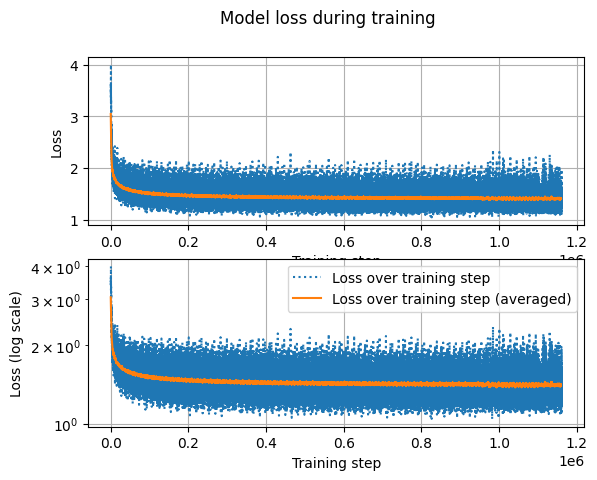

In [7]:
import matplotlib.pyplot as plt

def moving_average(serie, n=2048):
    ret = np.cumsum(serie, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

losses = []

with open(f'{OUTPUTS_DIR}/phonemes_training.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        losses.append(float(row[3]))

fig, axes = plt.subplots(2, 1)
fig.suptitle("Model loss during training")
axes[0].plot(losses, label="Loss over training step", linestyle='dotted')
axes[0].plot(moving_average(losses), label="Loss over training step (averaged)")
axes[0].grid()
axes[0].set_xlabel("Training step")
axes[0].set_ylabel("Loss")

axes[1].plot(losses, label="Loss over training step", linestyle='dotted')
axes[1].plot(moving_average(losses), label="Loss over training step (averaged)")
axes[1].set_yscale('log')
axes[1].grid()
axes[1].set_xlabel("Training step")
axes[1].set_ylabel("Loss (log scale)")

plt.legend()
plt.show()

## Performances analysis

Check how good is the linear classifier model.

In [8]:
import evaluate

cer_metric = evaluate.load("cer")


state_dict, increment = load_last_checkpoint(MODEL_DIR, "linear_mapper")
print("loading step", increment)
linear_mapper.load_state_dict(state_dict)

linear_mapper.eval().to(device)

clear_cache()

with torch.no_grad():
    features_dataset = features_dataset.map(
        lambda data_row: {
            "reference": "".join(data_row["target_phonemes1"]),
            "prediction": "".join(linear_mapper.classify_to_phonemes(linear_mapper(
                data_row["features"].unsqueeze(0).to(device), 
                data_row["language"]
            ))[0])
        },
        desc="Generating predictions"
    )

cer = cer_metric.compute(
    references=features_dataset["reference"], predictions=features_dataset["prediction"]
)
print(f"Phoneme error rate: {cer * 100}%")

loading step 69632


Generating predictions: 100%|██████████| 16384/16384 [01:16<00:00, 215.10 examples/s]


Phoneme error rate: 48.36986383120585%


## Model fine-tuning

Now we want to increase performances.
The It means fine-tuning the full model (WavLM + LinearMapper) that was already pre-trained.

In [ ]:
from src.phoneme_recognizer import PhonemeRecognizer

linear_mapper.eval()
phoneme_recognizer = PhonemeRecognizer(wavlm_model, linear_mapper)
phoneme_recognizer.to(device).train()

recognizer_optimizer = torch.optim.Adam(
    phoneme_recognizer.parameters(),
    lr=5e-4,
    weight_decay=1e-5
)


prepare_folders()

use_pretrained_models = True
base_name = "phoneme_recognizer"
if use_pretrained_models:
    phoneme_recognizer.wavlm = WavLMModel.from_pretrained("microsoft/wavlm-base-plus").to(device)

    # Try loading the state for the linear layer first
    state_dict, increment_linear = load_last_checkpoint(MODEL_DIR, "linear_mapper")
    print(f"Using step {increment_linear} on linear model")
    if state_dict is not None:
        phoneme_recognizer.phoneme_classifier.load_state_dict(state_dict)

    increment = 0
else:
    state_dict, increment = load_last_checkpoint(MODEL_DIR, base_name)
    # Load the rest
    if state_dict is not None:
        phoneme_recognizer.load_state_dict(state_dict)
    print(f"Using step {increment} on complete model")

def write_to_csv(row):
    with open(f'{OUTPUTS_DIR}/phonemes_training_complete.csv', 'a') as file:
        writer = csv.writer(file)
        writer.writerow(row)


clear_cache()

batch_size = 4
coders = (("1", "2") if USE_IN_HOUSE else ("1", ))

dataset = dataset.shuffle()
# Training loop
for epoch in range(600):
    progress_bar = tqdm.trange(0, dataset.num_rows, batch_size)
    for i in progress_bar:
        # Skip the incomplete batches as there would change all sizes
        if i + batch_size > dataset.num_rows:
            continue
        batch_data = dataset[i:i + batch_size]

        inputs = preprocess_audios(batch_data["audio"], device=device)
        inputs["language"] = batch_data["language"]

        input_lengths = torch.tensor([int(len(x["array"]) / 16000 * 50) - 1 for x in batch_data["audio"]], device=device)

        log_probs = phoneme_recognizer(**inputs)

        loss = torch.zeros(0, device=device, dtype=log_probs.dtype)

        for coder in coders:
            targets = [
                phoneme_recognizer.tokenize(string)
                for string in batch_data[f"target_phonemes{coder}"]
            ]
            target_lengths = torch.empty(batch_size, dtype=torch.uint8, device=device)
            max_len = max(map(lambda x: x.shape[0], targets))

            target_batch = torch.zeros((batch_size, max_len), device=device)
            for j, target in enumerate(targets):
                target_batch[j, :target.shape[0]] = target
                target_lengths[j] = target.shape[0]

            final_probs = log_probs.transpose(0, 1)

            loss += F.ctc_loss(
                final_probs,
                target_batch,
                input_lengths=input_lengths,
                target_lengths=target_lengths
            )

        loss /= len(coders)
        
        recognizer_optimizer.zero_grad()
        loss.backward()
        recognizer_optimizer.step()
        for j in range(batch_size):
            pred_phoneme = "".join(linear_mapper.classify_to_phonemes(log_probs[j, :input_lengths[j]].unsqueeze(0))[0])
            target_phons1 = "".join(batch_data["target_phonemes1"][j])
            data_row = [
                increment, epoch, i, loss.item(), pred_phoneme, target_phons1
            ]
            if len(coders) == 2:
                data_row.append("".join(batch_data["target_phonemes2"]))
            write_to_csv(data_row)
        progress_bar.set_postfix({"epoch": epoch, "loss": loss.item()})
        increment += 1
    torch.save(
        phoneme_recognizer.state_dict(),
        f"{MODEL_DIR}/{base_name}_epoch_{epoch}_step_{i}_{increment}.pth"
    )
    

Using step 69632 on linear model


  0%|          | 0/4096 [00:00<?, ?it/s]/home/hugo/Documents/dev/asr/Lemanic-Life-Sciences-Hackathon-2025/.venv/lib/python3.12/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  7%|▋         | 291/4096 [00:29<06:31,  9.72it/s, epoch=27, loss=1.14] 


ValueError: Unable to create tensor, you should probably activate padding with 'padding=True' to have batched tensors with the same length.

## Fine-tuning results

Let's see how the fine-tuning changed results.

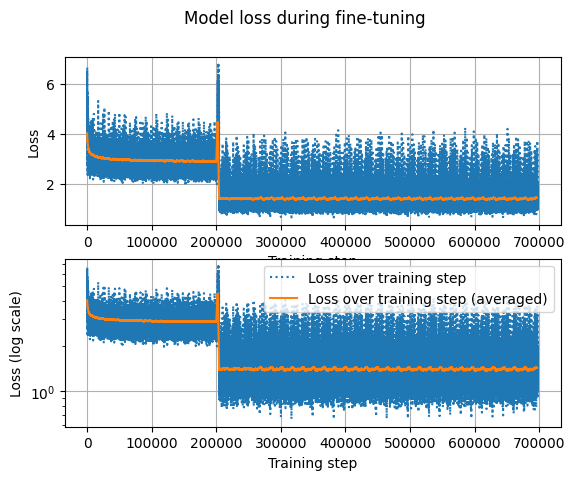

Loading step 110592


Generating predictions: 100%|██████████| 16384/16384 [14:40<00:00, 18.61 examples/s]  


Phoneme error rate: 50.46641464704563%


In [10]:
losses = []

with open(f'{OUTPUTS_DIR}/phonemes_training_complete.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        losses.append(float(row[3]))

fig, axes = plt.subplots(2, 1)
fig.suptitle("Model loss during fine-tuning")
axes[0].plot(losses, label="Loss over training step", linestyle='dotted')
axes[0].plot(moving_average(losses), label="Loss over training step (averaged)")
axes[0].grid()
axes[0].set_xlabel("Training step")
axes[0].set_ylabel("Loss")

axes[1].plot(losses, label="Loss over training step", linestyle='dotted')
axes[1].plot(moving_average(losses), label="Loss over training step (averaged)")
axes[1].set_yscale('log')
axes[1].grid()
axes[1].set_xlabel("Training step")
axes[1].set_ylabel("Loss (log scale)")

plt.legend()
plt.show()


base_name = "phoneme_recognizer"
state_dict, increment = load_last_checkpoint(MODEL_DIR, base_name)
print("Loading step", increment)
phoneme_recognizer.load_state_dict(state_dict)
phoneme_recognizer.eval().to(device)

clear_cache()

with torch.no_grad():
    dataset = dataset.map(
        lambda data_row: {
            "reference": "".join(data_row["target_phonemes1"]),
            "prediction": "".join(phoneme_recognizer.classify_to_phonemes(phoneme_recognizer(
                **preprocess_audios([data_row["audio"]], device=device), 
                language=data_row["language"]
            ))[0])
        },
        desc="Generating predictions"
    )

cer = cer_metric.compute(
    references=dataset["reference"], predictions=dataset["prediction"]
)
print(f"Phoneme error rate: {cer * 100}%")

## Binary classification

We have a model roughly trained for phonemes.
We want a binary classification though.

Two strategies:

1. We consider the model reliable on phonemes, the task is a string search. We don't need AI.
2. We call for hidden complexity, ans we use some NLP for the classification.

Once we have everything, we could build an end-to-end pipeline, but we won't do it for now.

In [ ]:
from src.word_detector import binary_classifier
from src.phoneme_recognizer import PhonemeRecognizer


in_house_dataset = get_in_house_dataset(LANGUAGES)

# Remove Italian (scoring different words) and DELETION (it has a different penalty system)
in_house_dataset = (
    in_house_dataset
    .filter(lambda x: x["language"] == "fr" and x["phase"] == "REPETITION")
    .cast_column("audio", datasets.Audio(sampling_rate=16_000))
    .map(
        lambda x: {"target": tuple(x[1:-1])},
        input_columns=["API_target"],
        desc="Formatting target"
    ).select(range(120))
)
phoneme_recognizer = PhonemeRecognizer(wavlm_model, linear_mapper)
state_dict, increment = load_last_checkpoint(MODEL_DIR, "phoneme_recognizer")
print("Loading step", increment)
phoneme_recognizer.load_state_dict(state_dict)
phoneme_recognizer.eval().to(device)
batch_size = 4
results = []
for i in tqdm.trange(0, in_house_dataset.num_rows, batch_size):
    batch = in_house_dataset[i:i + batch_size]
    inputs = preprocess_audios(batch["audio"], device=device)
    inputs["language"] = batch["language"]
    logits = phoneme_recognizer(**inputs)
    phonemes = phoneme_recognizer.classify_to_phonemes(logits)
    print(phonemes, batch["target"])
    try:
        embed = phoneme_recognizer.get_embedding(batch["target"])
    except KeyError:
        continue
    for pred, em, acc1, acc2 in zip(logits, embed, batch["accuracy_coder1"], batch["accuracy_coder2"]):
        score = binary_classifier.get_alignment_score(pred, em.unsqueeze(0), [1, 1, 0.1])
        if score != 0:
            print('aaaaaaaaaaaaaaaaa')
        elif False:
            print("bbbbbb")
        results.append((score, acc1, acc2))
    
results


Formatting target: 100%|██████████| 1928/1928 [00:00<00:00, 8159.13 examples/s]


Loading step 8


  0%|          | 0/30 [00:00<?, ?it/s]/home/hugo/Documents/dev/asr/Lemanic-Life-Sciences-Hackathon-2025/.venv/lib/python3.12/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/home/hugo/Documents/dev/asr/Lemanic-Life-Sciences-Hackathon-2025/src/word_detector/binary_classifier.py:196: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits = torch.tensor(prediction)
  7%|▋         | 2/30 [00:00<00:01, 16.17it/s]

[[], ['m'], [], []] [['p', 'l', 'a', 'b', 'i', 'ʁ'], ['f', 'ʁ', 'ɔ', 'm', 'a', 'ʒ'], ['b', 'a', 'n', 'e', 'ɔ', '̃'], ['k', 'ɔ', '̃', 'd', 'a']]
[[], [], [], []] [['ʃ', 'ə', 'v', 'a', 'l'], ['p', 'ɔ', 'l', 'a', 'ʒ'], ['ɡ', 'l', 'w', 'a', 'ʁ'], ['ɡ', 'l', 'ɔ', 'm', 'ɔ']]
[[], [], [], []] [['k', 'a', 'n', 'a', 'ʁ', 'i'], ['s', 'p', 'a', 'l', 'i', 'ɔ'], ['m', 'i', 'k', 'ã'], ['b', 'a', 't', 'o']]
[['t'], [], ['k', 'm'], []] [['k', 'a', 'p', 'i', 't', 'a', 'l'], ['s', 'ɔ', 'ʁ', 's', 'j', 'ɛ', 'ʁ'], ['b', 'ʁ', 'ɔ', 'm', 'a', 'l'], ['t', 'ʁ', 'i', 'f']]


 23%|██▎       | 7/30 [00:00<00:01, 14.00it/s]

[[], [], [], []] [['p', 'l', 'a', 'ʒ'], ['s', 'p', 'a', 't', 'y', 'l'], ['s', 'o', 'l', 'y', 's', 'j', 'ɔ', '̃'], ['t', 'ʁ', 'u', 'f']]
[[], [], [], []] [['ɡ', 'l', 'ɛ', 'z'], ['p', 'a', 'n', 'y', 'ʒ'], ['s', 'p', 'i', 'ʁ', 'a', 'l'], ['p', 'o', 'ʒ', 'j', 'ɔ', '̃']]
[[], [], ['d'], ['m']] [['ɡ', 'l', 'ɔ', 'm', 'e'], ['ɡ', 'a', 't', 'ɔ'], ['f', 'ʁ', 'i', 'ɡ', 'ɔ'], ['k', 'a', 'm', 'e', 'ʁ', 'a']]
[[], [], ['l'], ['l', 't']] [['l', 'a', 'ʒ', 'ɔ', '̃'], ['k', 'a', 'ʁ', 'a', 'v', 'a', 'n'], ['p', 'l', 'a', 'b', 'ɛ', 't'], ['p', 'l', 'a', 'k']]
[[], [], ['t'], []] [['ʃ', 'a', 'p', 'o'], ['p', 'ɔ', '̃', 'b', 'ɛ', '̃'], ['p', 'ʁ', 'o', 't', 'a', 'l'], ['s', 'p', 'y', 'd', 'j', 'ɔ']]
[[], ['k'], [], []] [['ɡ', 'l', 'ɔ', 'm', 'ɔ'], ['k', 'ɔ', '̃', 'd', 'a'], ['p', 'l', 'a', 'ʒ'], ['b', 'a', 't', 'o']]


 40%|████      | 12/30 [00:00<00:00, 21.67it/s]

[[], [], [], []] [['p', 'o', 'ʒ', 'j', 'ɔ', '̃'], ['s', 'o', 'l', 'y', 's', 'j', 'ɔ', '̃'], ['p', 'a', 'n', 'y', 'ʒ'], ['s', 'p', 'y', 'd', 'j', 'ɔ']]
[[], ['p'], [], []] [['l', 'a', 'ʒ', 'ɔ', '̃'], ['s', 'p', 'i', 'ʁ', 'a', 'l'], ['p', 'ʁ', 'o', 't', 'a', 'l'], ['k', 'a', 'ʁ', 'a', 'v', 'a', 'n']]
[[], ['b'], ['k'], []] [['k', 'a', 'm', 'e', 'ʁ', 'a'], ['p', 'l', 'a', 'b', 'ɛ', 't'], ['f', 'ʁ', 'i', 'ɡ', 'ɔ'], ['p', 'ɔ', '̃', 'b', 'ɛ', '̃']]
[[], [], [], []] [['ʃ', 'a', 'p', 'o'], ['p', 'l', 'a', 'k'], ['ɡ', 'a', 't', 'ɔ'], ['ɡ', 'l', 'ɛ', 'z']]


 67%|██████▋   | 20/30 [00:00<00:00, 25.70it/s]

[[], [], [], []] [['ɡ', 'l', 'ɔ', 'm', 'e'], ['t', 'ʁ', 'u', 'f'], ['s', 't', 'a', 's', 'j', 'ɔ', '̃'], ['ɡ', 'l', 'ɔ', 't', 'y']]
[['t'], ['m'], [], []] [['ʁ', 'a', 't', 'ɔ'], ['ʃ', 'ə', 'm', 'ɛ', '̃'], ['ʁ', 'a', 'z', 'ɛ', '̃'], ['k', 'a', 'm', 'a', 'ʁ', 'a', 'd']]
[['i', 't'], ['t'], [], ['t']] [['s', 'o', 'l', 'i', 't', 'y', 'd'], ['ʁ', 'a', 't', 'ɔ'], ['s', 't', 'a', 's', 'j', 'ɔ', '̃'], ['ɡ', 'l', 'ɔ', 't']]
[['m'], [], [], []] [['ʃ', 'ə', 'm', 'ɛ', '̃'], ['ɡ', 'l', 'ɔ', 't', 'y'], ['p', 'l', 'a', 'd', 'a', 'ʁ'], ['p', 'o', 'b', 'j', 'e']]
[[], [], ['t', 'k', 'l'], []] [['k', 'a', 'n', 'a', 'p', 'e'], ['f', 'ʁ', 'i', 's', 'ɔ', '̃'], ['t', 'ʁ', 'i', 'k', 'a', 'l'], ['s', 'p', 'e', 'ʁ', 'e', 'o']]
[['t'], ['k', 't', 'n'], [], ['t']] [['p', 'l', 'i', 'k'], ['ɡ', 'a', 't', 'i', 'n'], ['p', 'l', 'y', 'm'], ['ɡ', 'ã', 'd', 'a']]
[['k', 'k'], [], [], ['l', 'ʁ', 'l', 'm']] [['k', 'ɔ', '̃', 'd', 'a'], ['ʃ', 'ə', 'v', 'a', 'l'], ['b', 'a', 't', 'o'], ['ɡ', 'l', 'ɔ', 'm', 'ɔ']]
[[], ['a'], 

 77%|███████▋  | 23/30 [00:01<00:00, 15.24it/s]

[[], [], [], []] [['b', 'a', 'n', 'e', 'ɔ', '̃'], ['ɡ', 'l', 'w', 'a', 'ʁ'], ['s', 'p', 'a', 't', 'y', 'l'], ['m', 'i', 'k', 'ã']]
[[], [], ['a'], []] [['s', 'ɔ', 'ʁ', 's', 'j', 'ɛ', 'ʁ'], ['p', 'l', 'a', 'ʒ'], ['p', 'ɔ', 'l', 'a', 'ʒ'], ['k', 'a', 'n', 'a', 'ʁ', 'i']]


 93%|█████████▎| 28/30 [00:01<00:00, 14.00it/s]

[['m'], [], [], ['t']] [['b', 'ʁ', 'ɔ', 'm', 'a', 'l'], ['s', 'p', 'a', 'l', 'i', 'ɔ'], ['p', 'ɔ', '̃', 'b', 'ɛ', '̃'], ['k', 'a', 'ʁ', 'a', 'v', 'a', 'n']]
[['k'], ['t'], ['g'], ['k', 'l', 'a', 'b', 't']] [['k', 'a', 'm', 'e', 'ʁ', 'a'], ['ʃ', 'a', 'p', 'o'], ['f', 'ʁ', 'i', 'ɡ', 'ɔ'], ['p', 'l', 'a', 'b', 'ɛ', 't']]
[[], [], [], ['p']] [['ɡ', 'l', 'ɔ', 'm', 'e'], ['s', 'p', 'y', 'd', 'j', 'ɔ'], ['p', 'l', 'a', 'k'], ['s', 'p', 'i', 'ʁ', 'a', 'l']]
[['d'], [], [], []] [['ɡ', 'a', 't', 'ɔ'], ['l', 'a', 'ʒ', 'ɔ', '̃'], ['p', 'a', 'n', 'y', 'ʒ'], ['t', 'ʁ', 'u', 'f']]


100%|██████████| 30/30 [00:01<00:00, 16.61it/s]

[[], ['t'], [], []] [['s', 'o', 'l', 'y', 's', 'j', 'ɔ', '̃'], ['p', 'ʁ', 'o', 't', 'a', 'l'], ['ɡ', 'l', 'ɛ', 'z'], ['p', 'o', 'ʒ', 'j', 'ɔ', '̃']]
[[], ['g'], [], []] [['p', 'a', 'n', 'y', 'ʒ'], ['ɡ', 'ã', 'd', 'a'], ['p', 'l', 'a', 'd', 'a', 'ʁ'], ['ɡ', 'a', 't', 'i', 'n']]


[(0, 1.0, 1.0),
 (0, 0.0, 0.0),
 (0, 0.0, 0.0),
 (0, 0.0, 0.0),
 (0, 0.0, 1.0),
 (0, 1.0, 1.0),
 (0, 0.0, 0.0),
 (0, 1.0, 1.0),
 (0, 1.0, 1.0),
 (0, 1.0, 1.0),
 (0, 0.0, 0.0),
 (0, 1.0, 1.0),
 (0, 1.0, 1.0),
 (0, 0.0, 1.0),
 (0, 1.0, 1.0),
 (0, 0.0, 0.0),
 (0, 0.0, 0.0),
 (0, 1.0, 1.0),
 (0, 0.0, 0.0),
 (0, 0.0, 0.0),
 (0, 0.0, 0.0),
 (0, 0.0, 0.0),
 (0, 1.0, 1.0),
 (0, 0.0, 1.0),
 (0, 1.0, 1.0),
 (0, 1.0, 1.0),
 (0, 1.0, 1.0),
 (0, 1.0, 1.0),
 (0, 1.0, 1.0),
 (0, 1.0, 1.0),
 (0, 1.0, 1.0),
 (0, 1.0, 1.0)]